




# Projet Fil Rouge 2023 : Reconnaissance de commandes audio


**Noms :**

**Prénoms :**

**Nom du binôme :**




Ces 12 séances de TP vont vous permettre de tester l'algorithme de programmation dynamique vu en CTD puis de réaliser la mise en oeuvre d'un système de reconnaissance audio de mots isolés (constituant des
commandes pour les drones).

<img src="DroneJS.jpg" width="600" height="500"  >



Ces séances se décomposent en ces parties : 
- Partie I : Prétraitement des données 
- Partie II : Sélection de variables et pénalisation
- Partie III : Classification par méthodes à noyau 
- Partie IV : Apprentissage par ensemble : Adaboost, gradient boosting
- Partie V : Classification par réseaux de neurones
- Partie VI : Votre étude




In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import sklearn
import math
import numpy.random as rnd
import seaborn as sns
import librosa
from os import listdir
from os.path import isfile, join
import glob
import re
import warnings
warnings.filterwarnings('ignore')

# Partie I : Prétraitement des données 

Sur l'espace moodle, vous trouverez un dossier d'enregistrements audio de mots de commandes pour un drone quadricoptère constitués de plusieurs locuteurs masculins (notés M01..M13) et locutrice féminines (F01..F05) pour quelques commandes. 


In [3]:
data = [] 
label = [] 
genres = []
min_duration = None
words = ['avance','recule','tournegauche']
list_genres = ['M', 'F']

for file_name in glob.glob('FichierTest/*.wav'):
    record = librosa.load(file_name)[0]
    data.append(record)
    # Computation of the minimal size of recordings
    if min_duration is None or record.shape[0] < min_duration:
        min_duration = record.shape[0] 
    
    # Creation of the vector of label
    for i, word in enumerate(words):
      if re.search(word, file_name):
        label.append(i)

    # Creation of the vector of label
    for i, genre in enumerate(list_genres):
      if re.search(genre, file_name[12:]):# 12 is for ignoring "FichierTest/"
        genres.append(genre)

fs = librosa.load(file_name)[1] # Sampling frequency
genres = np.array(genres)
print(f'The smallest record contains {min_duration} samples, and the sample frequency is {fs} Hz')


The smallest record contains 18522 samples, and the sample frequency is 22050 Hz


### We trim the recordings to isolate the word and have identical durations
The smallest record contains 18 522 samples. We are going to cut all recordings to be of this size.

In [4]:

def trim(record):
    half_duration = 18522//2

    # First, we compute the barycenter of energy along time. We interpret it as the moment when the word appears
    barycenter = int(np.floor(np.multiply(np.power(record,2),np.arange(0,record.shape[0],1)).sum()/np.power(record,2).sum()))

    # Second, we adjust the barycenter to be in the index range
    if barycenter-half_duration < 0:
        barycenter += half_duration-barycenter
    if barycenter+half_duration >= record.shape[0]:
        barycenter -= barycenter+half_duration - record.shape[0]
    
    # Finally, we trim the recording around the barycenter 
    return record[barycenter-half_duration:barycenter+half_duration]

In [5]:
X = np.empty((len(data),min_duration))
for i in range(len(data)):
    X[i,:] = trim(data[i])

y = np.array(label)
print(f'Shape of inputs X is{X.shape} and size of targets class is {y.shape}')

Shape of inputs X is(54, 18522) and size of targets class is (54,)


### Spectral representation

1. Apply a Fourrier transform on the signals in $X$ using the function fft of scipy. Explain why the resulting dimension is too large to apply logistic regression.

2. Let $\hat{X}$ be the fourier transform of $X$. Apply a PCA on $|\hat{X}|$ and plot the total explained variance in function of the numer of components.

In [6]:
from scipy import signal
from scipy.fft import fft

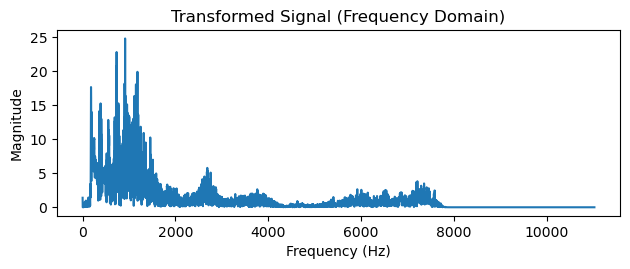

In [7]:


# Apply Fourier transformation
transformed_signal = fft(X,axis=1)


# Frequency axis for plotting
x_axis = np.linspace(0.0, 1.0/2.0*fs, X.shape[1]//2)
y_axis=transformed_signal[0]

# Plot the transformed signal in the frequency domain
plt.subplot(2, 1, 2)
plt.plot(x_axis[:transformed_signal.shape[1]//2], np.abs(y_axis[:transformed_signal.shape[1]//2]))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Transformed Signal (Frequency Domain)')

# Display the plots
plt.tight_layout()
plt.show()






In [8]:
X.shape

(54, 18522)

The number of variables (number of frequencies = columns) is much higher than the number of samples (rows). Thus, estimations of the parameters will not be accurate because there will be too much overfitting.

In [9]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

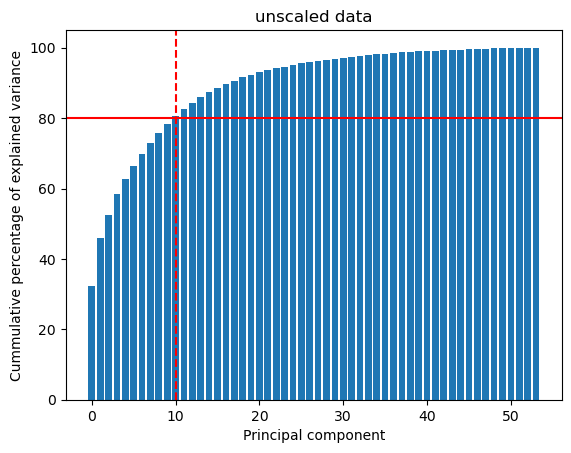

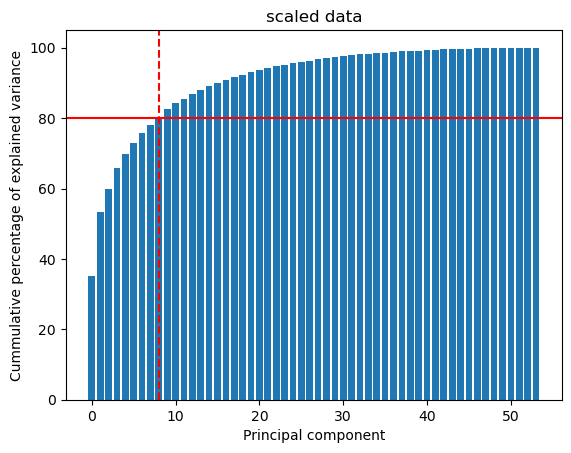

In [10]:
X_abs = np.abs(transformed_signal)
X_pca = PCA().fit(X_abs)

plt.bar(np.arange(X_pca.n_components_), np.cumsum(X_pca.explained_variance_ratio_ * 100))
plt.xlabel("Principal component")
plt.ylabel("Cummulative percentage of explained variance")
plt.title("unscaled data")
plt.axhline(y=80, color="r")
plt.axvline(x=10, color="r", linestyle='--')
plt.show()

plt.clf()
X_scaled = StandardScaler().fit_transform(X_abs)
X_pca = PCA().fit(X_scaled)

plt.bar(np.arange(X_pca.n_components_), np.cumsum(X_pca.explained_variance_ratio_ * 100))
plt.xlabel("Principal component")
plt.ylabel("Cummulative percentage of explained variance")
plt.title("scaled data")
plt.axhline(y=80, color="r")
plt.axvline(x=8, color="r", linestyle='--')
plt.show()

3. Apply a Short Term Fourier Transform on $X$. What are the dimension of stft $\hat{X}[t,f]$?

4. Make 2 subplots (3x3) of the stft (as images with function .imshow()) with three instances of each words, one for male and one for female 

(127, 147)


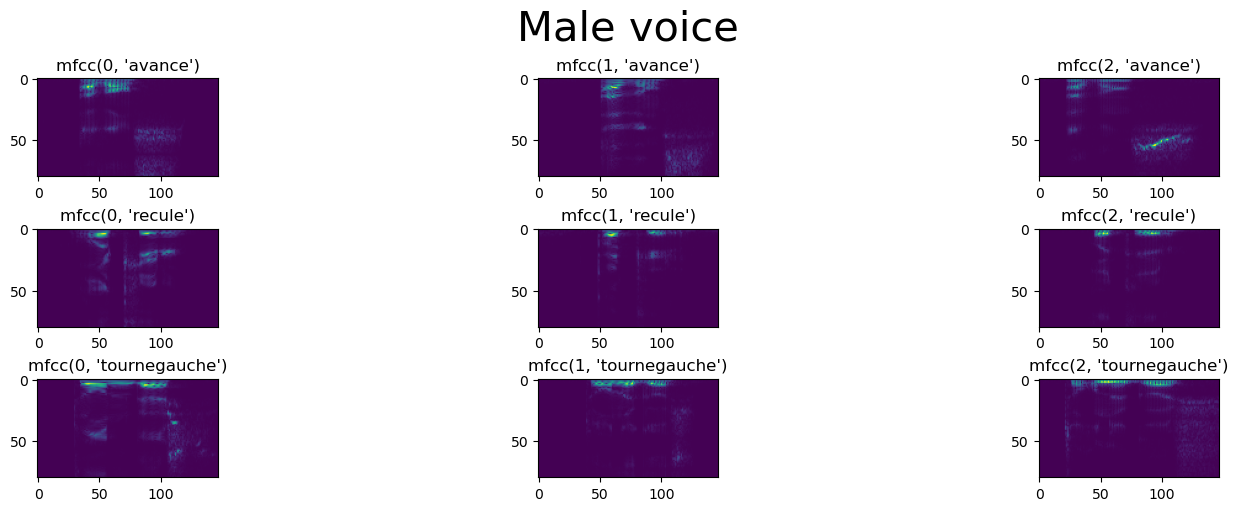

In [11]:
nperseg = 253

fig, axs = plt.subplots(3, 3, constrained_layout=True, figsize=(15,5))
for i,word in enumerate(words):
    for instance in range(3):

        record = X[(y==i) & (genres == 'M')][instance]
        f, t, Zxx = signal.stft(record, fs=fs, window='hann', nperseg=nperseg, noverlap=None)
        axs[i,instance].imshow(np.absolute(Zxx[:80]))
        axs[i,instance].set_title(f'mfcc{instance,word}')

        
print(Zxx.shape)
fig.suptitle("Male voice", fontsize=30)
plt.show()

(127, 147)


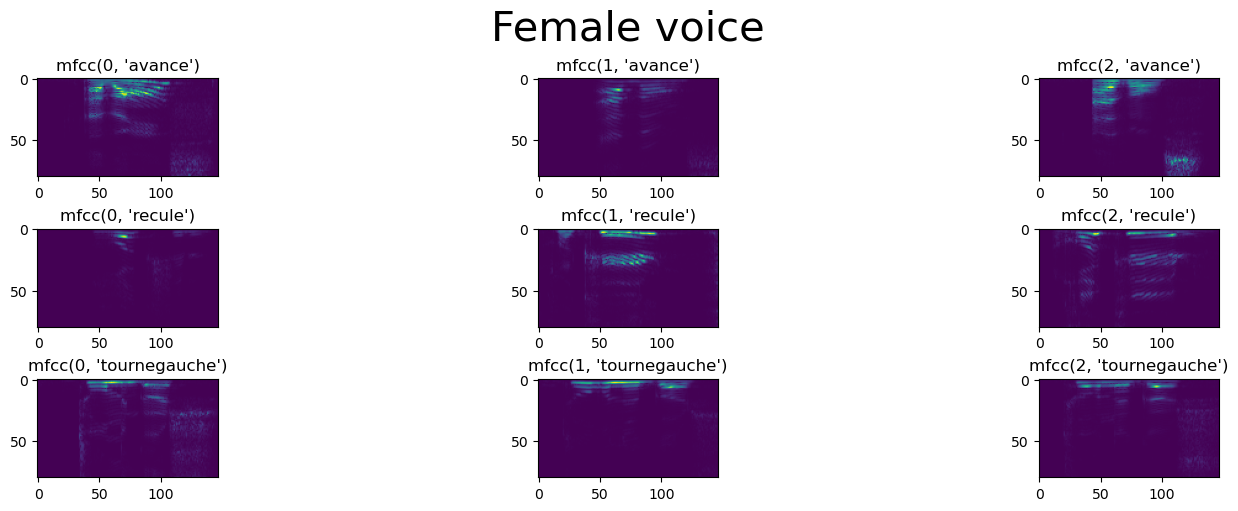

In [16]:
nperseg = 253

fig, axs = plt.subplots(3, 3, constrained_layout=True, figsize=(15,5))
for i,word in enumerate(words):
    for instance in range(3):

        record = X[(y==i) & (genres == 'F')][instance]
        f, t, Zxx = signal.stft(record, fs=fs, window='hann', nperseg=nperseg, noverlap=None)
        axs[i,instance].imshow(np.absolute(Zxx[:80]))
        axs[i,instance].set_title(f'mfcc{instance,word}')

print(Zxx.shape)
fig.suptitle("Female voice", fontsize=30)
plt.show()

Dimensions of $\hat{X}[t,f]$ are (127, 147)

#### Now we will build sklearn transformers to extract features

Create a class STFT in the same spirit as FFT. 
Add a first argument to choose between returning different statistics (mean, quantile, max...) along time such that each signal. Add a second argument that gives the maximum frequency index 

In [17]:
from sklearn.base import BaseEstimator, TransformerMixin

In [18]:
class FFT(BaseEstimator, TransformerMixin):
    def __init__(self, idx_frequence_max=None):
        self.idx_frequence_max = idx_frequence_max
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        # Perform arbitary transformation        
        return np.absolute(fft(X)[:self.idx_frequence_max])

In [19]:
class STFT(BaseEstimator, TransformerMixin):
    def __init__(self, statistic=None, idx_frequence_max=None):
        self.idx_frequence_max = idx_frequence_max
        self.statistic = statistic
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        # Perform arbitary transformation
        _, _, signal_stft = signal.stft(X, axis=1)
        signal_stft_norm = np.absolute(signal_stft)
        return self.statistic(signal_stft_norm[:self.idx_frequence_max, :], axis=1)

In [20]:
fft_object = FFT()
X_fft = fft_object.transform(X)
X_fft.shape

(54, 18522)

In [21]:
stft_object = STFT(np.max)
X_stft = stft_object.transform(X)
X_stft.shape

(54, 146)

# Partie II : Sélection de variables et pénalisation

### 1. Multiclass regression


Apply a **multiclass regression** model.

We model the probabilities by the following form :

$$
\mathbb{P}(Y_i = j) = \frac { \exp^{-\beta_j^{T} X_i } } {1 + \sum_{\ell = 1}^{K-1} \exp^{-\beta_\ell^{T} X_i }}, 
$$
For all $j$ in $\{ 1,2, \dots , K-1 \}$.

### Objective

Try to apply a logistic regression with **Leave one out Cross validation** on :

1. The first PCA components of FFT (try multiple "n_components")
2. Different statistics and maximum frequency of the STFT
3. The same as before with scaling

In each situations try different regularization coefficient C.

To simplify use the **pipeline** function of sklearn. You can also use the function **GridSearchCV** with cv = X.shape[0] to vary the parameters of preprocessing and logistic regression. You can acess to all results with "cv_results_"



In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score

In [ ]:
# Create the pipeline
pipeline = Pipeline([
    ('fft', FFT()),  
    ('pca', PCA()),  # PCA transformation
    ('scaler', StandardScaler()),  # Standardization
    ('logistic', LogisticRegression())  # Logistic regression model
])

# Define the parameter grid for hyperparameter tuning
params = {
    'pca__n_components': [3, 5, 7],  # Number of PCA components to consider
    'logistic__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 10000],  # Regularization strength
    'logistic__solver': ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga'],  # Solver algorithm
    'logistic__multi_class': ['ovr', 'multinomial']  # Multi-class strategy
}

# Create the grid search object with leave-one-out cross-validation
grid_search = GridSearchCV(pipeline, params, cv=LeaveOneOut(), n_jobs=-1)

# Fit the grid search model on your data
model = grid_search.fit(X, y)

In [27]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'logistic__C': 100, 'logistic__multi_class': 'multinomial', 'logistic__solver': 'lbfgs', 'pca__n_components': 7}
0.7777777777777778


In [1]:
# Apply Fourier transformation
transformed_signal = fft(X,axis=1)

signal_abs=np.abs(transformed_signal)
# Define the range of values for C
C_values = np.arange(50,100,1)

accuracies = []

# Iterate over the C values
for C_val in C_values:
    # Create and apply PCA transformation
    pca = PCA(n_components=7)
    X_pca = pca.fit_transform(signal_abs)
    
    # Apply standardization
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_pca)
    
    # Create and fit the logistic regression model
    logistic = LogisticRegression(C=C_val, solver='lbfgs', multi_class='multinomial')
    
    # Perform leave-one-out cross-validation and calculate accuracy
    current_accuracies = []
    for train_index, test_index in LeaveOneOut().split(X_scaled):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        logistic.fit(X_train, y_train)
        y_pred = logistic.predict(X_test)
        current_accuracies.append(accuracy_score(y_test, y_pred))
    
    mean_accuracy = np.mean(current_accuracies)
    accuracies.append(mean_accuracy)

# Plot the results
plt.plot(C_values, accuracies, marker='o')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title('Effect of Changing C on Model Performance')
plt.show()



NameError: name 'fft' is not defined

In [ ]:
# Create the pipeline
pipeline = Pipeline([
    ('stft', STFT()),  
    ('scaler', StandardScaler()),  # Standardization
    ('logistic', LogisticRegression())  # Logistic regression model
])

# Define the parameter grid for hyperparameter tuning
params = {
    'logistic__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 10000],  # Regularization strength
    'logistic__solver': ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga'],  # Solver algorithm
    'logistic__multi_class': ['ovr', 'multinomial'],  # Multi-class strategy
    "stft__statistic": [np.mean,np.max,np.min],
    'stft__idx_frequence_max': [100, 200, 300]  # Maximum frequency of the STFT
}

# Create the grid search object with leave-one-out cross-validation
grid_search = GridSearchCV(pipeline, params, cv=LeaveOneOut(), n_jobs=-1)

# Fit the grid search model on your data
model = grid_search.fit(X, y)

In [30]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'logistic__C': 1, 'logistic__multi_class': 'multinomial', 'logistic__solver': 'saga', 'stft__idx_frequence_max': 200, 'stft__statistic': <function amin at 0x7fb0380c6af0>}
0.7407407407407407


###  Evaluation des résultats 

Evaluer le résultat par matrice de confusion et pourcentage de bonne classification.

*Conseil :* Pensez à mettre une fonction pour afficher la matrice de confusion

In [34]:
# Evaluation des résultats par matrices de confusion 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [39]:
confusion_matrix(y, model.best_estimator_.predict(X))


array([[18,  0,  0],
       [ 0, 18,  0],
       [ 0,  0, 18]])

In [43]:
confusion_mat=np.array([[12,  6,  0],
       [ 1, 16,  1],
       [ 0,  4, 14]])
correct = confusion_matrix(y, model.best_estimator_.predict(X)).trace() # Somme elements diagonaux
total = sum(sum(confusion_mat))
accuracy = correct / total
accuracy

1.0


# Partie III : Classification par méthodes à noyau

**Rappel** Les méthodes à noyau consistent à plonger les données dans un espace de dimension de Hilbert $\mathcal{H}$ ou les donnés pourront être séparé linéairement. 

**Theorème de Représentation :** La solution du problème de séparation en dimension infinie est contenue dans un sous espace vectoriel de dimension finie de $\mathcal{H}$ 

### 1. Réaliser une classification par SVM à noyau


In [44]:
from sklearn.svm import SVC
from sklearn.svm import NuSVC

In [45]:
svm=SVC()
# Create the pipeline
pipeline = Pipeline([  
    ('scaler', StandardScaler()),  # Standardization
    ('stft', STFT()),
    ('svm',svm)  # Logistic regression model
])

# Define the parameter grid for hyperparameter tuning
params = {
    "stft__statistic": [np.mean,np.max,np.min],
    "stft__idx_frequence_max": [100, 200, 300],  # Maximum frequency of the STFT
    'svm__C': [0.001, 0.01, 0.1, 1, 10],  # Regularization parameter
    'svm__kernel': ['linear', 'rbf', 'poly'],  # Kernel type
    'svm__gamma': ['scale', 'auto']  # Kernel coefficient
    }

# Create the grid search object with leave-one-out cross-validation
grid_search = GridSearchCV(pipeline, params, cv=LeaveOneOut(), n_jobs=-1)

# Fit the grid search model on your data
model = grid_search.fit(X, y)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scip

In [46]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'stft__idx_frequence_max': 100, 'stft__statistic': <function amax at 0x7fb0380c6940>, 'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
0.6666666666666666


### 1 - appliquer une pca + SVC rbf et créer une fonction qui plot les frontières de décisions

In [47]:
def plot_svc_decision_boundary(X, y,model=None, h=1):

    #check if it s trained
    previously_trained = model is not None
    if not previously_trained:
        #train data
        X_fft = FFT(idx_frequence_max=55).transform(X)
        X_pca = PCA(n_components=2).fit_transform(X_fft)
        model = GridSearchCV(SVC(kernel="rbf", gamma=4e-6), param_grid=dict(), cv=LeaveOneOut(), n_jobs=-1).fit(X_pca, y)
    else:
        X_pca = X
        
    # Define the meshgrid of the feature space
    x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
    y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                    np.arange(y_min, y_max, h))
    #print("prediction")
    # Generate predictions for each point in the meshgrid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    #print("plotting")
    # Plot the decision boundaries and the training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, edgecolors='k')


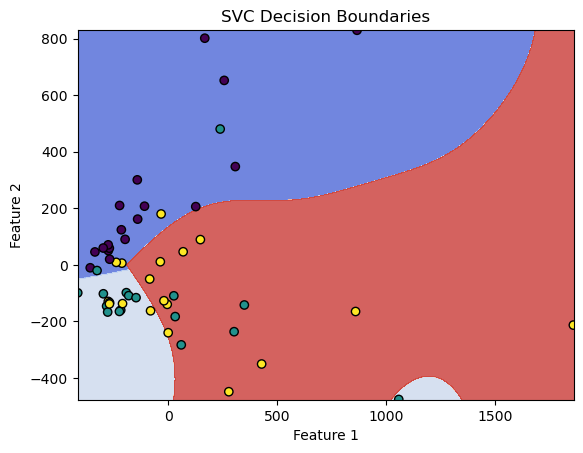

In [48]:
plot_svc_decision_boundary(X, y)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('SVC Decision Boundaries')
plt.show()

In [49]:
confusion_matrix(y, model.best_estimator_.predict(X))

array([[18,  0,  0],
       [ 0, 18,  0],
       [ 0,  0, 18]])

In [50]:
accuracy_score(model.best_estimator_.predict(X), y)

1.0

#### 1) Varier le noyau

Fitting 54 folds for each of 1 candidates, totalling 54 fits
Fitting 54 folds for each of 1 candidates, totalling 54 fits
Fitting 54 folds for each of 1 candidates, totalling 54 fits
Fitting 54 folds for each of 1 candidates, totalling 54 fits


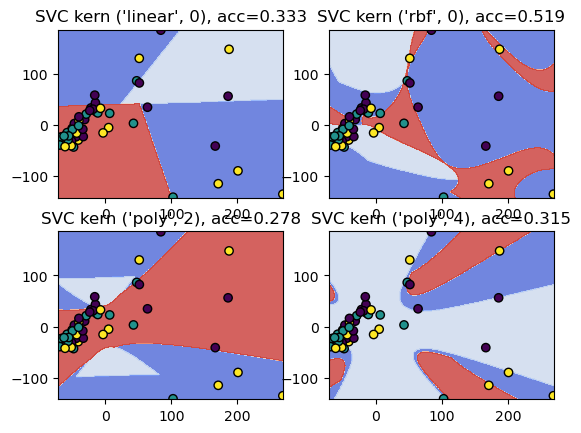

In [63]:
fig, axs = plt.subplots(2, 2)
kernels = [
    ("linear", 0),
    ("rbf", 0),
    ("poly", 2),
    ("poly", 4),
]
pipeline = Pipeline(steps = [("fft", FFT(idx_frequence_max=55)), ("scaler", StandardScaler()), ("pca", PCA(n_components=2))])
X_features = pipeline.fit_transform(X)

for i, k in enumerate(kernels):
    svm = NuSVC(nu=0.1, kernel=k[0], degree=k[1])
    model = GridSearchCV(svm, param_grid=dict(), cv=LeaveOneOut(), n_jobs=-1, verbose=1).fit(X_features, y).best_estimator_
    plt.subplot(2, 2, i+1)
    plot_svc_decision_boundary(X_features, y, model=model)
    plt.title('SVC kern {0}, acc={1:.3f}'.format(k, accuracy_score(model.predict(X_features), y)))
    
plt.show()

#### 2) Varier le paramètre de régularisation.
##### 2 - quelle est l'influence de $\gamma$ ? justifiez

Fitting 54 folds for each of 1 candidates, totalling 54 fits
Fitting 54 folds for each of 1 candidates, totalling 54 fits
Fitting 54 folds for each of 1 candidates, totalling 54 fits
Fitting 54 folds for each of 1 candidates, totalling 54 fits


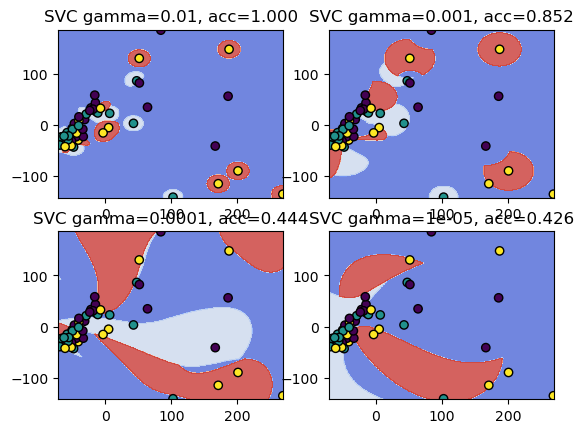

In [77]:
fig, axs = plt.subplots(2, 2)
gammas = [10**i for i in range(-2, -6, -1)]
pipeline = Pipeline(steps = [("fft", FFT(idx_frequence_max=55)), ("scaler", StandardScaler()), ("pca", PCA(n_components=2))])
X_features = pipeline.fit_transform(X)

for i, g in enumerate(gammas):
    svm = NuSVC(nu=0.1, kernel="rbf", gamma=g)
    model = GridSearchCV(svm, param_grid=dict(), cv=LeaveOneOut(), n_jobs=-1, verbose=1).fit(X_features, y).best_estimator_
    plt.subplot(2, 2, i+1)
    plot_svc_decision_boundary(X_features, y, model=model)
    plt.title('SVC gamma={0}, acc={1:.3f}'.format(g, accuracy_score(model.predict(X_features), y)))
    
plt.show()

##### 3 - quelle est l'influence de C ? justifiez

Fitting 54 folds for each of 1 candidates, totalling 54 fits
Fitting 54 folds for each of 1 candidates, totalling 54 fits
Fitting 54 folds for each of 1 candidates, totalling 54 fits
Fitting 54 folds for each of 1 candidates, totalling 54 fits


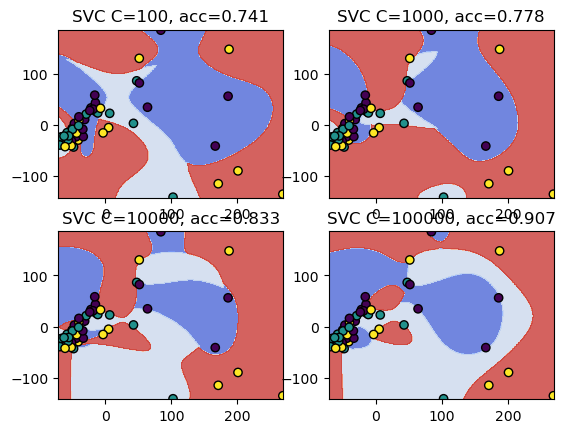

In [82]:
fig, axs = plt.subplots(2, 2)
Cs = [10**i for i in range(2, 6)]
pipeline = Pipeline(steps = [("fft", FFT(idx_frequence_max=55)), ("scaler", StandardScaler()), ("pca", PCA(n_components=2))])
X_features = pipeline.fit_transform(X)

for i, c in enumerate(Cs):

    svm = SVC(C=c, kernel="rbf", gamma=2e-4)

    model = GridSearchCV(svm, param_grid=dict(), cv=LeaveOneOut(), n_jobs=-1, verbose=1).fit(X_features, y).best_estimator_

    plt.subplot(2, 2, i+1)
    plot_svc_decision_boundary(X_features, y, model=model)
    plt.title('SVC C={0}, acc={1:.3f}'.format(c, accuracy_score(model.predict(X_features), y)))

plt.show()

# Partie IV : Apprentissage par ensemble : Bootstrap Aggregation, Adaboost, gradient boosting

## 1. Bootstrap Aggregation : Bagging

Boostrap consists in creating multiple data sets as follows. Suppose our
original data set consists of $N$ data points $X = \{x_1,..., x_N \}$. We can create a new
data set $X_B$ by drawing $N$ points at random from X, with replacement, so that some
points in $X$ may be replicated in $X_B$, whereas other points in $X$ may be absent from
$X_B$. This process can be repeated $L$ times to generate $L$ data sets each of size $N$ and
each obtained by sampling from the original data set $X$.

Consider a binary classification problem in which we are trying to predict the class, and suppose we generate $M$ bootstrap data sets and then use each to train a separate copy $y_m(x)$ of a classifier where $m = 1,...,M$. The committee prediction is given by voting with all $M$ models.



In [84]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

**Question 1 :**  Transform $y$ in $y^1$ as follow
if $y = 1$, then $y^1 = 1$
if $y = 0$ or $y = 2$, then $y^1 = 0$
Now we can apply binary classification


In [96]:
y1 = (y==1)


**Question 2 :**  Code from scratch the Bagging of Decision trees with *max_depth = 2* only and compare the accuracy of the bagging model with the mean accuracy of the models and conclude. (the bootstrap is done on the training set with np.random.choice, and use $M=100$)


In [93]:
d=np.arange(0.1,0.99,0.1)
mean_axis=[0 for i in range(len(d))]
bagging_axis=[0] * len(d)
for s in range(3):
    m=[]
    b=[]
    for t in np.arange(0.2,0.8,0.1):
        # Load your dataset and split it into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(X, y1, test_size=t, random_state=42)

        # Define the base decision tree model
        base_model = DecisionTreeClassifier(max_depth=2)

        # Define the number of models in the ensemble
        M = 100

        # Create a list to store the individual model accuracies
        individual_accuracies = []

        # Create an array to store the predictions of each model
        predictions = np.zeros((M, X_test.shape[0]))

        # Implement Bagging with Decision Trees
        for i in range(M):
            # Create a bootstrap sample of the training set
            bootstrap_indices = np.random.choice(X_train.shape[0], size=X_train.shape[0], replace=True)
            X_bootstrap = X_train[bootstrap_indices]
            y_bootstrap = y_train[bootstrap_indices]

            # Train an individual decision tree on the bootstrap sample
            model = DecisionTreeClassifier(max_depth=2)
            model.fit(X_bootstrap, y_bootstrap)

            # Predict on the test set
            y_pred = model.predict(X_test)
            predictions[i] = y_pred

            # Calculate the accuracy of the individual model
            accuracy = accuracy_score(y_test, y_pred)
            individual_accuracies.append(accuracy)

        # Calculate the mean accuracy of the individual models
        mean_accuracy = np.mean(individual_accuracies)

        # Create the bagging model by combining the predictions of all individual models
        bagging_predictions = np.round(np.mean(predictions, axis=0))

        # Calculate the accuracy of the bagging model
        bagging_accuracy = accuracy_score(y_test, bagging_predictions)

        # Compare the accuracy of the bagging model with the mean accuracy of the individual models
#         print("t:",t)
#         print("Mean Accuracy of Individual Models:", mean_accuracy)
#         print("Bagging Accuracy:", bagging_accuracy)

        m.append(mean_accuracy)
        b.append(bagging_accuracy)
    
    
    mean_axis=[e+f for e, f in zip(m, mean_axis)]
    bagging_axis=[e+f for e, f in zip(b, bagging_axis)]


In [94]:
mean_axis=[e/3 for e in mean_axis]
bagging_axis=[e/3 for e in bagging_axis]

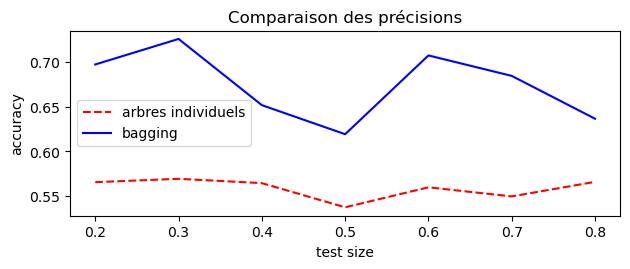

In [97]:
# Plot the transformed signal in the frequency domain
plt.subplot(2, 1, 2)
plt.plot(np.arange(0.2,0.8,0.1), mean_axis, 'r--', label='arbres individuels')
plt.plot(np.arange(0.2,0.8,0.1), bagging_axis, 'b-', label='bagging')
plt.xlabel('test size')
plt.ylabel('accuracy')
plt.title('Comparaison des précisions')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()


On peut voir que l'utilisation du bagging avec des arbres de décision (max_depth=2) a amélioré la précision de la tâche de classification par rapport à l'utilisation d'arbres de décision individuellements.

Le modèle de bagging atteint une précision plus élevée que la précision moyenne des modèles individuels, et cela pour une base d'entrainement petite ou grande par rapport à la base de test.
Cela suggère que l'ensemble d'arbres de décision créé par le bagging a amélioré la performance prédictive globale.
Le bagging permet de réduire la variance, en capturant une plus grande diversité de features, mais aussi d'augmenter la stabilité et la robustesse du modèle en agrégeant les prédictions de plusieurs modèles formés sur différents échantillons bootstrap. Le bagging a ainsi une meilleure capacité à généraliser.

**Question 3 :** Apply Random Forest on the initial classification problem (3 classes) and adjust the hyperparameters. Is random Forest a Bagging model?

In [99]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [100]:
scaled_signal = StandardScaler().fit_transform(X)
transformed_signal = STFT(statistic=np.max, idx_frequence_max=100).transform(scaled_signal)

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier()

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

# Create the GridSearchCV object with cross-validation
grid_search = GridSearchCV(rf_classifier, param_grid, cv=LeaveOneOut(), n_jobs=-1)

# Fit the grid search model on the training data
grid_search.fit(transformed_signal, y)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Calculate the accuracy of the model
accuracy = grid_search.best_score_

# Print the best hyperparameters and accuracy
print("Best Hyperparameters:", best_params)
print("Random Forest Accuracy:", accuracy)


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scip

Best Hyperparameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
Random Forest Accuracy: 0.7592592592592593


Oui, Random Forest est un type de modèle d'ensemble qui utilise le bagging pour agréger plusieurs arbres de décision. Chaque arbre de décision de la Random Forest est formé sur un échantillon bootstrap du jeu de données d'entraînement, puis, les prédictions de chaque arbre sont combinées en une prédiction finale du modèle. Les Random Forest améliorent le bagging en minimisant la corrélation entre arbres : il réduit le risque d'overfiting, améliore la robustesse et la précision.

D'après les résultats du gridsearch, les meilleurs hyperparamètres pour le modèle Random Forest sont les suivants :

* Critère : 'gini'
* Profondeur max : Aucune (profondeur illimitée)
* Fractionnement minimal des échantillons : 5
* Nombre d'estimateurs : 100

La précision du modèle Random Forest est supérieure à la précision maximale de la moyenne des modèles individuels et à la précision maximale du modèle Bagging. Cela suggère que le modèle Random Forest est plus performant en termes de précision que les modèles individuels et le modèle Bagging.

## 2. Adaptative boosting : AdaBoost

Here is the algorithm Adaboost

1. Initialize the data weighting coefficients ${w_n}$ by setting $w_n^{(1)} = 1/N$ for $n = 1,...,N$.
2. For $m = 1,...,M$:
    
    **(a)** Fit a classifier $y_m(x)$ to the training data by minimizing the weighted
error function
    
    $J_m = \sum_{n=1}^N{w_n^{(m)}I(y_m(x)\neq t_n)}$

    where $I(y_m(x)\neq t_n)$ is the indicator function and equals $1$ when $y_m(x_n) 	\neq t_n$ and $0$ otherwise

    **(b)** Evaluate the quantities

    $\epsilon_m = \frac{\sum_{n=1}^N{w_n^{(m)}I(y_m(x)\neq t_n)}}{\sum_{n=1}^N{w_n^{(m)}}}$

    and then use these to evaluate

    $\alpha_m = \textit{ln}\left({\frac{1-\epsilon_m}{\epsilon_m}}\right)$

    **(c)** Update the data weighting coefficients
    
    $w_n^{(m+1)} = w_n^{(m)} \textit{exp}\left({\alpha_m I(y_m(x_n) \neq t_n)}\right)$

3. Make predictions using the final model, which is given by

    $Y_M(x) = \text{sign}\left(\sum_{m=1}^M {\alpha_m y_m(x)}\right)$


**Question 1 :** Code from scratch the Adaboost algorithm in the same configuration as Bagging in the previous section. Use the sklearn decision tree classifier and its argument *sample_weight*. Compare its performances with Bagging.


In [115]:
y1 = (y==1).astype(int)
y1[y1==0]=-1


def adaboost(X_train, y_train, X_test, y_test, n_estimators=100):
    N = X_train.shape[0]
    sample_weights = np.ones(N) / N
    estimators = []
    estimator_weights = []
    estimator_errors = []

    for _ in range(n_estimators):
        estimator = DecisionTreeClassifier(max_depth=2)
        estimator.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = estimator.predict(X_train)

        incorrect = y_pred != y_train
        error = np.mean(np.average(incorrect, weights=sample_weights, axis=0))
        if error == 0:
            estimators.append(estimator)
            estimator_weights.append(1.0)
            estimator_errors.append(error)
            break

        alpha = np.log((1 - error) / error) / 2
        sample_weights *= np.exp(alpha * incorrect)
        sample_weights /= np.sum(sample_weights)

        estimators.append(estimator)
        estimator_weights.append(alpha)
        estimator_errors.append(error)

    y_pred = np.zeros(X_test.shape[0])
    for estimator, weight in zip(estimators, estimator_weights):
        y_pred += weight * estimator.predict(X_test)

    predictions = np.sign(y_pred)
    accuracy = accuracy_score(y_test, predictions)
    return accuracy


accuracy_axis=[]

for t in np.arange(0.2,0.8,0.1):
    X_train, X_test, y_train, y_test = train_test_split(X,y1,test_size=t, random_state=42)
    accuracy = adaboost(X_train, y_train, X_test, y_test, n_estimators=100)
    accuracy_axis.append(accuracy)
    print("Adaboost Accuracy:", accuracy)
    

Adaboost Accuracy: 0.6363636363636364
Adaboost Accuracy: 0.6470588235294118
Adaboost Accuracy: 0.4090909090909091
Adaboost Accuracy: 0.5357142857142857
Adaboost Accuracy: 0.6666666666666666
Adaboost Accuracy: 0.6578947368421053
Adaboost Accuracy: 0.5681818181818182


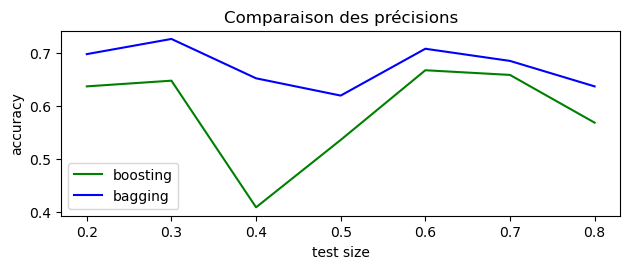

In [116]:
# Plot the transformed signal in the frequency domain
plt.subplot(2, 1, 2)
plt.plot(np.arange(0.2,0.8,0.1), accuracy_axis, 'g-', label='boosting')
plt.plot(np.arange(0.2,0.8,0.1), bagging_axis, 'b-', label='bagging')
plt.xlabel('test size')
plt.ylabel('accuracy')
plt.title('Comparaison des précisions')
plt.legend()
plt.tight_layout()
plt.show()

On peut voir que quelle que soit la taille du jeu d'entrainement,le boosting semble avoir de moins bonnes précisions sur le jeu de test. En effet, la capacité du boosting à généraliser et bien moins forte que celle du bagging.

**Question 2 :** 
With sklearn library, apply adaboost with decision tree (*max_depth=2*) on the 3-class classification problem. Find good parameters with the leave one out cross validation. Do the same thing with Gradient bossting.
If you have the time, you can test with XGBoost.


In [132]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

In [118]:
scaled_signal = StandardScaler().fit_transform(X)
transformed_signal = STFT(statistic=np.max, idx_frequence_max=55).transform(scaled_signal)

adaboost_clf = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=2))
adaboost_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.5, 1.0]
}
adaboost_grid = GridSearchCV(adaboost_clf, adaboost_params, cv=LeaveOneOut(),n_jobs=-1 )
adaboost_grid.fit(transformed_signal, y)

best_adaboost_clf = adaboost_grid.best_estimator_
adaboost_accuracy = adaboost_grid.best_score_
print("Adaboost Accuracy:", adaboost_accuracy)


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scip

Adaboost Accuracy: 0.6851851851851852


In [119]:
gb_clf = GradientBoostingClassifier()
gb_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.5, 1.0],
    'max_depth': [2, 3, 4]
}
gb_grid = GridSearchCV(gb_clf, gb_params, cv=LeaveOneOut(),n_jobs=-1)
gb_grid.fit(transformed_signal, y)

best_gb_clf = gb_grid.best_estimator_
gb_accuracy = gb_grid.best_score_
print("Gradient Boosting Accuracy:", gb_accuracy)

Gradient Boosting Accuracy: 0.7592592592592593


In [135]:
import xgboost

gb_clf = xgboost.XGBClassifier()
gb_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.001, 0.1, 0.5, 1.0],
    'max_depth': [2, 3, 4, 5]
}
gb_grid = GridSearchCV(gb_clf, gb_params, cv=LeaveOneOut(), n_jobs=-1)
gb_grid.fit(transformed_signal, y)

best_gb_clf = gb_grid.best_estimator_
gb_accuracy = gb_grid.best_score_
print("XGBoosting Accuracy:", gb_accuracy)

XGBoosting Accuracy: 0.6851851851851852


On peut voir que les modèles d'amélioration du boosting permettent de compenser les faiblesses en généralisation du par rapport au bagging voire des random forest et atteindre une précision similaire.

# Partie IV : Neural Network with pytorch

Below we create torch tensor with the shape $(N,B,F)$, where
    
$N$ is the number of recordings in the set (train/test)

$B$ the size of batch, we choose $B=1$ because the dataset is really small

$F$ is the number of features

The tensors are converted to float type

The train set and test set constitute 50% of the initial dataset

**Transform X with your preprocessing**

In [172]:
import torch
import torch.nn as nn
### transform X with your preprocessings
# transformed_signal = STFT(statistic=np.mean, idx_frequence_max=100).transform(X)

X_scaled = StandardScaler().fit_transform(X)
transformed_signal = STFT(statistic=np.max, idx_frequence_max=55).transform(X_scaled)

X_train, X_test, y_train, y_test = train_test_split(transformed_signal,y,test_size=0.5, random_state=42)
X_train = torch.tensor(X_train).reshape((X_train.shape[0],1,-1)).float()
X_test = torch.tensor(X_test).reshape((X_test.shape[0],1,-1)).float()
y_train = torch.nn.functional.one_hot(torch.tensor(y_train), num_classes=- 1).reshape((X_train.shape[0],1,-1)).float()
y_test = torch.nn.functional.one_hot(torch.tensor(y_test), num_classes=- 1).reshape((X_test.shape[0],1,-1)).float()

In [173]:
X_train[0].shape

torch.Size([1, 146])

**Question 1:** : Create a model class (descending from torch.nn.Module). In a first time choose the appropriate architecture and the appropriate loss (the loss appear later) to reproduce logistic regression

Usually a FNN is a succession of blocks (linear -> ReLU). Finally the networks transforms the initial vector into the output $\hat{y} \in \mathbb{R}^3, \hat{y}=(\mathbb{P}(y=0|x),\mathbb{P}(y=1|x),\mathbb{P}(y=2|x))$ where $y$ is the word we want to predict and $x \in \mathbb{R}^{18522}$ is the accoustic signal

    

In [416]:
class NNClassification(nn.Module):
    def __init__(self):
        super(NNClassification, self).__init__()
        self.network = torch.nn.Sequential(
            
            ### Define here the succession of torch.nn modules that will constitutes your network
            ### building blocks are torch.nn.ReLU, torch.nn.Linear
            torch.nn.Linear(146,300),
            torch.nn.ReLU(),
            torch.nn.Linear(300,100),
            torch.nn.ReLU(),
            torch.nn.Linear(100,3)
        )
    
    def forward(self, xb):
        ### the forward method will be called each time you will write model(x). 
        ### It's equivalent to the function predict of sklearn
        return torch.nn.functional.softmax(self.network(xb), dim=-1)

In [417]:
print(model)

NNClassification(
  (network): Sequential(
    (0): Linear(in_features=146, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=3, bias=True)
  )
)


In [418]:
model = NNClassification()
num_epochs = 100

result_test_loss = []
result_train_loss=[]

lr = 0.001
optimizer = torch.optim.Adam(model.parameters(),lr)
loss =torch.nn.functional.cross_entropy### What loss do you think is well suited for the classification problem (same as logistic regression)

for epoch in range(num_epochs):

    model.train()
    train_losses = []
    for i in range(X_train.shape[0]):
       ### training step (compute loss -> optimization step -> save the loss )
        optimizer.zero_grad()
        loss_train = loss(model(X_train[i]),y_train[i])

        # Optimization step
        loss_train.backward()
        optimizer.step()
        
        train_losses.append(loss_train)
        
    model.eval()
    test_losses = []
    for i in range(X_test.shape[0]):
        ###eval step  (compute loss -> save the loss )
        loss_test=loss(model(X_test[i]),y_test[i])
        
        test_losses.append(loss_test)

    result_train_loss.append(torch.stack(train_losses).mean().item())
    result_test_loss.append( torch.stack(test_losses).mean().item())



Question 2: Plot the train and test loss. What do you observe?

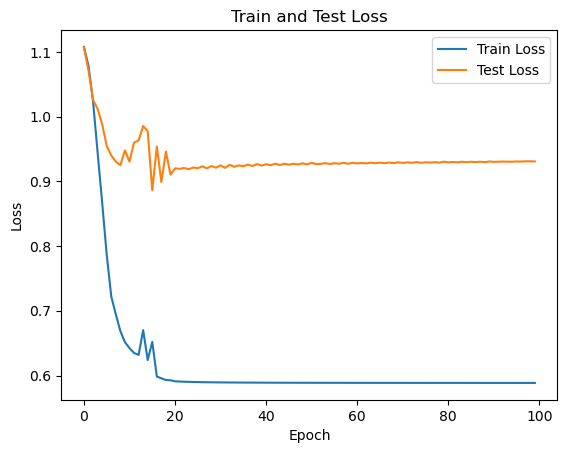

In [419]:
# Plot train and test loss
plt.plot(range(num_epochs), result_train_loss, label='Train Loss')
plt.plot(range(num_epochs), result_test_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss')
plt.legend()
plt.show()

On peut observer qu'il y a de l'overfiting : la perte sur le set d'entrainement est clairement inférieure à la perte sur le set de test. Nous pourrons d'ailleurs le confirmer en observant la précision sur le set d'entrainement et de test.

Question 3 : Compute the accuracy.

In [420]:
predictions_train = torch.argmax(model(X_train), dim=2)
accuracy_train = (predictions_train == y_train.argmax(dim=2)).numpy().mean()

predictions_test = torch.argmax(model(X_test), dim=2)
accuracy_test = (predictions_test == y_test.argmax(dim=2)).numpy().mean()

print('Train set accuracy : {}'.format(accuracy_train))
print('Test set accuracy : {}'.format(accuracy_test))
print('-----------------')

Train set accuracy : 0.9629629629629629
Test set accuracy : 0.5925925925925926
-----------------


Question 4: If you encounter overfitting try to regularize your model with Dropout and/or L2/L1 Regularization

In [481]:
class NNClassification_Dropout(nn.Module):
    def __init__(self):
        super(NNClassification_Dropout, self).__init__()
        self.network = torch.nn.Sequential(
            
            ### Define here the succession of torch.nn modules that will constitutes your network
            ### building blocks are torch.nn.ReLU, torch.nn.Linear
            torch.nn.Linear(146,300),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.3),
            torch.nn.Linear(300,200),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.2),
            torch.nn.Linear(200,50),
            torch.nn.ReLU(),
            torch.nn.Linear(50,3)
        )
    
    def forward(self, xb):
        ### the forward method will be called each time you will write model(x). 
        ### It's equivalent to the function predict of sklearn
        return torch.nn.functional.softmax(self.network(xb), dim=-1)

In [488]:
model_drop = NNClassification_Dropout()
num_epochs = 100

result_test_loss = []
result_train_loss=[]

lr = 0.001

l2_lambda = 1e-5 # L2 regularization parameter
l1_lambda = 1e-4 # L1 regularization parameter

optimizer = torch.optim.Adam(model_drop.parameters(),lr, weight_decay=l2_lambda)
loss =torch.nn.functional.cross_entropy### What loss do you think is well suited for the classification problem (same as logistic regression)

for epoch in range(num_epochs):

    model_drop.train()
    train_losses = []
    for i in range(X_train.shape[0]):
       ### training step (compute loss -> optimization step -> save the loss )
        optimizer.zero_grad()
        loss_train = loss(model_drop(X_train[i]),y_train[i])
        
        # L1 regularization
        l1_regularization = torch.tensor(0.0)
        for param in model_drop.parameters():
            l1_regularization += torch.norm(param, p=1)
        loss_train += l1_lambda * l1_regularization

        # L2 regularization
        l2_regularization = torch.tensor(0.0)
        for param in model.parameters():
            l2_regularization += torch.norm(param, p=2)
        loss_train += l2_lambda * l2_regularization
        
        # Optimization step
        loss_train.backward()
        optimizer.step()
        
        train_losses.append(loss_train)
        
    model_drop.eval()
    test_losses = []
    for i in range(X_test.shape[0]):
        ###eval step  (compute loss -> save the loss )
        loss_test=loss(model_drop(X_test[i]),y_test[i])
        
        test_losses.append(loss_test)

    result_train_loss.append(torch.stack(train_losses).mean().item())
    result_test_loss.append( torch.stack(test_losses).mean().item())

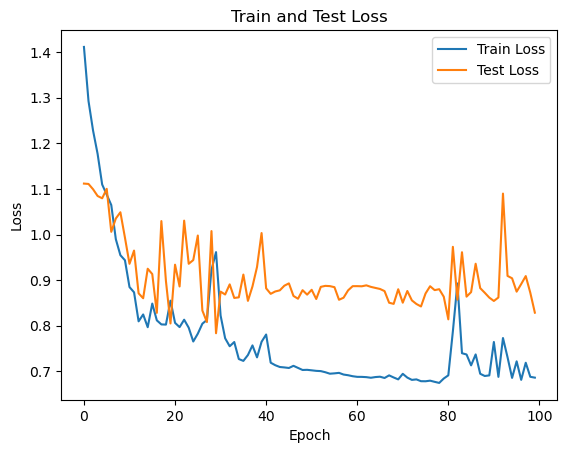

In [489]:
# Plot train and test loss
plt.plot(range(num_epochs), result_train_loss, label='Train Loss')
plt.plot(range(num_epochs), result_test_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss')
plt.legend()
plt.show()

In [490]:
predictions_train = torch.argmax(model_drop(X_train), dim=2)
accuracy_train = (predictions_train == y_train.argmax(dim=2)).numpy().mean()

predictions_test = torch.argmax(model_drop(X_test), dim=2)
accuracy_test = (predictions_test == y_test.argmax(dim=2)).numpy().mean()

print('Train set accuracy : {}'.format(accuracy_train))
print('Test set accuracy : {}'.format(accuracy_test))
print('-----------------')

Train set accuracy : 0.9629629629629629
Test set accuracy : 0.7407407407407407
-----------------


On peut voir que l'on peut palier au problème d'overfiting en appliquant des régularisations. Cependant, cela a tout de même une influence limitée, sachant que la phase d'entrainement est impactée par ces régularisations

Question 5(Bonus) : Create a CNN that takes in input the accoustic signal without preprocessing